In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
crashes = pd.read_csv('../data/clean/crashes.csv')
crashes.describe()

,Unnamed: 0,accident_number,number_of_motor_vehicles,number_of_injuries,number_of_fatalities,reporting_officer,zip,rpa,lat,long
count,7274.000000,7.274000e+03,7274.000000,7274.000000,7274.0,7.273000e+03,7270.000000,7270.000000,7269.000000,7269.000000
mean,90819.412015,2.019534e+10,1.825406,0.441985,0.0,7.335528e+05,37154.355846,1606.261073,36.238892,-86.724281
std,52169.908214,1.993812e+07,0.737168,0.805250,0.0,1.149628e+06,48.205398,576.921745,0.042791,0.022818
min,15.000000,2.017000e+10,0.000000,0.000000,0.0,1.010640e+05,37013.000000,1101.000000,36.073300,-86.817700
25%,45412.250000,2.018036e+10,2.000000,0.000000,0.0,2.069620e+05,37115.000000,1425.000000,36.197000,-86.741600
50%,91244.500000,2.019060e+10,2.000000,0.000000,0.0,3.113330e+05,37115.000000,1607.000000,36.248700,-86.719900
75%,136352.000000,2.021042e+10,2.000000,1.000000,0.0,4.933040e+05,37206.000000,1731.000000,36.264400,-86.711500
max,180785.000000,2.024015e+10,7.000000,8.000000,0.0,4.013729e+06,37228.000000,15921.000000,36.319600,-86.443800


In [3]:
crashes.isna().sum(axis = 0)

Unnamed: 0                    0
accident_number               0
date_and_time                 0
number_of_motor_vehicles      0
number_of_injuries            0
number_of_fatalities          0
hit_and_run                   0
reporting_officer             1
collision_type_description    0
weather_description           0
illumination_description      0
harmfuldescriptions           0
street_address                0
city                          0
state                         0
zip                           4
rpa                           4
precinct                      0
lat                           5
long                          5
property_damage               0
date                          0
dtype: int64

Location data is important for the first step of identifying "hot spots", so any nulls in these columns will need to be addressed. The records with nulls for location fields (`lat`, `long`, & `mapped_location`) do seem to be from actual events and not errors, but given that at the time of this analysis they represent 0.04% of the data, I don't believe removeing them will negatively impact the overall analysis.

In [4]:
crashes = crashes.dropna()

In [5]:
crashes.isna().sum(axis = 0)

Unnamed: 0                    0
accident_number               0
date_and_time                 0
number_of_motor_vehicles      0
number_of_injuries            0
number_of_fatalities          0
hit_and_run                   0
reporting_officer             0
collision_type_description    0
weather_description           0
illumination_description      0
harmfuldescriptions           0
street_address                0
city                          0
state                         0
zip                           0
rpa                           0
precinct                      0
lat                           0
long                          0
property_damage               0
date                          0
dtype: int64

In [6]:
crashes.to_csv('../data/clean/crashes.csv')

No fatalities are reported in the entire dataset, which is surprising. However, these reports are only as accurate as the officers recording them, and they may be busy attending to those involved and quickly filling these out as soon as they arrive or or after they've left. That said, I will ignore the column for this analysis but leave it in the dataset, so it can be used in the future if numbers start showing up.

Now let's look at some other data sets that may have an impact on road safety.

First, 311 Complaints:

In [7]:
nash_311 = pd.read_csv('../data/clean/nash_311.csv')
nash_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11176 entries, 0 to 11175
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 11176 non-null  int64  
 1   case_number                11176 non-null  int64  
 2   status                     11176 non-null  object 
 3   case_request               11176 non-null  object 
 4   case_subrequest            11176 non-null  object 
 5   additional_subrequest      11176 non-null  object 
 6   date_time_opened           11176 non-null  object 
 7   date_time_closed           11051 non-null  object 
 8   case_origin                11176 non-null  object 
 9   state_issue                11176 non-null  bool   
 10  closed_when_created        11176 non-null  bool   
 11  incident_address           11176 non-null  object 
 12  incident_city              11176 non-null  object 
 13  incident_council_district  11176 non-null  obj

In [8]:
nash_311.isna().sum(axis = 0)

Unnamed: 0                     0
case_number                    0
status                         0
case_request                   0
case_subrequest                0
additional_subrequest          0
date_time_opened               0
date_time_closed             125
case_origin                    0
state_issue                    0
closed_when_created            0
incident_address               0
incident_city                  0
incident_council_district      0
incident_zip_code            204
latitude                      31
longitude                     31
mapped_location               31
contact_type                   0
parent_case                    0
preferred_language             0
dtype: int64

In [9]:
nash_311 = nash_311.dropna(subset=['latitude', 'longitude'])

In [10]:
nash_311.to_csv('../data/clean/nash_311.csv')

Short-term rental properties in the area (for the purpose of this study, defined as all properties in zip codes 37206, 37216, & 37115) may inflence driver behavior, as guests staying here are either driving themselves and may not be familiar with their surroundings or are using ride-share services whose drivers also may not be familiar with the area.

In [11]:
st_rentals = pd.read_csv('../data/clean/rentals.csv')
st_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872 entries, 0 to 2871
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  2872 non-null   int64  
 1   index                       2872 non-null   int64  
 2   permit                      2872 non-null   object 
 3   applicant                   2872 non-null   object 
 4   contact                     2871 non-null   object 
 5   permit_subtype_description  2872 non-null   object 
 6   permit_status               2872 non-null   object 
 7   parcel                      2872 non-null   object 
 8   date_entered                2872 non-null   object 
 9   date_issued                 2574 non-null   object 
 10  expiration_date             2872 non-null   object 
 11  address                     2872 non-null   object 
 12  city                        2872 non-null   object 
 13  state                       2872 

Building permits and active right-of-way permits (construction occuring in the roadway) could cause congestion and unexpected slowdowns, which could lead to crashes.

In [12]:
bdlg_permits = pd.read_csv('../data/clean/bldg_permits.csv')

In [13]:
row_permits = pd.read_csv('../data/clean/row_permits.csv')

Nashville also maintains an inventory of pedestrian signals throughout the city, including information about their compliance with ADA regulations.

In [14]:
ped_inv = pd.read_csv('../data/clean/ped_inv.csv')

Now is a good time to pause and look at the all of this on a map.<br><br>
(This is better done in a separate notebook, so this will serve as a stopping point for this one. The current table will be exported to a .csv file and used in the mapping notebook. Refer to `mapping.ipynb` for the overall map(s) and next steps will follow below)

Now we'll look at the different categorical information in our datasets.

In [15]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7267 entries, 0 to 7273
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  7267 non-null   int64  
 1   accident_number             7267 non-null   int64  
 2   date_and_time               7267 non-null   object 
 3   number_of_motor_vehicles    7267 non-null   float64
 4   number_of_injuries          7267 non-null   float64
 5   number_of_fatalities        7267 non-null   float64
 6   hit_and_run                 7267 non-null   bool   
 7   reporting_officer           7267 non-null   float64
 8   collision_type_description  7267 non-null   object 
 9   weather_description         7267 non-null   object 
 10  illumination_description    7267 non-null   object 
 11  harmfuldescriptions         7267 non-null   object 
 12  street_address              7267 non-null   object 
 13  city                        7267 non-n

In [16]:
crashes['collision_type_description'].value_counts()

collision_type_description
ANGLE                                      2574
FRONT TO REAR                              2404
SIDESWIPE - SAME DIRECTION                 1033
NOT COLLISION W/MOTOR VEHICLE-TRANSPORT     661
HEAD-ON                                     211
SIDESWIPE - OPPOSITE DIRECTION              163
OTHER                                        90
REAR TO SIDE                                 57
UNKNOWN                                      40
REAR-TO-REAR                                 34
Name: count, dtype: int64

In [17]:
crashes['weather_description'].value_counts()

weather_description
CLEAR                     4967
CLOUDY                    1307
RAIN                       687
NAN                        239
SNOW                        28
UNKNOWN                     17
FOG                         12
OTHER (NARRATIVE)            4
SLEET, HAIL                  2
SEVERE CROSSWIND             1
BLOWING SAND/SOIL/DIRT       1
BLOWING SNOW                 1
SMOG, SMOKE                  1
Name: count, dtype: int64

As the overwhelming majority of crashes happen with clear or cloudy conditions, weather can be eliminated as a potential factor.

In [18]:
crashes['illumination_description'].value_counts()

illumination_description
DAYLIGHT                 4983
DARK - LIGHTED           1870
DUSK                      167
DARK - NOT LIGHTED        161
DAWN                       34
DARK-UNKNOWN LIGHTING      18
UNKNOWN                    14
NAN                        11
OTHER                       9
Name: count, dtype: int64

Same story for illumination, although it may be worth investigating the `DARK - NOT LIGHTED` instances to see if there is an issue with aparticular area.

In [19]:
crashes['harmfuldescriptions'].value_counts()

harmfuldescriptions
MOTOR VEHICLE IN TRANSPORT                                                                      6075
PARKED MOTOR VEHICLE                                                                             195
PEDESTRIAN                                                                                       184
UTILITY POLE                                                                                      98
MOTOR VEHICLE IN TRANSPORT;PARKED MOTOR VEHICLE                                                   96
                                                                                                ... 
MOTOR VEHICLE IN TRANSPORT;PARKED MOTOR VEHICLE;OTHER FIXED OBJECTS                                1
MOTOR VEHICLE IN TRANSPORT;PARKED MOTOR VEHICLE;DITCH;OTHER FIXED OBJECTS;RAN OFF ROAD-RIGHT       1
PARKED MOTOR VEHICLE;LUMINAIRE/LIGHT SUPPORT                                                       1
OTHER OBJECT (NOT FIXED);FENCE                                         

Could not find info specific to Tennessee but according to the state of Massachusetts, a "Collision with a motot vehicle in transport" means:<br><br>
"An event where a motor vehicle collides with another motor vehicle which is actively in motion on a roadway. This includes: motor vehicle in traffic on a highway, driverless motor vehicle in motion, motionless motor vehicle abandoned on a roadway, disabled motor vehicle on a roadway, etc."<br>(Source: https://masscrashreportmanual.com/vehicle/sequence-of-events-most-harmful-event/)<br><br>
So this count is simply telling us that the overwhelming majority of crashes involved a vehicle travelling down th eroad, as opposed to one that was not moving.<br><br>
It's worth looking at the collisions with pedestrians and parked vehicles. More on that later.

Now let's look at the different types of 311 complaints that have been made in the area.

In [20]:
nash_311.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11145 entries, 0 to 11175
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 11145 non-null  int64  
 1   case_number                11145 non-null  int64  
 2   status                     11145 non-null  object 
 3   case_request               11145 non-null  object 
 4   case_subrequest            11145 non-null  object 
 5   additional_subrequest      11145 non-null  object 
 6   date_time_opened           11145 non-null  object 
 7   date_time_closed           11023 non-null  object 
 8   case_origin                11145 non-null  object 
 9   state_issue                11145 non-null  bool   
 10  closed_when_created        11145 non-null  bool   
 11  incident_address           11145 non-null  object 
 12  incident_city              11145 non-null  object 
 13  incident_council_district  11145 non-null  object 


In [21]:
request_volume = nash_311['case_request'].value_counts().rename_axis('request_type').reset_index(name = 'requests')
request_volume[request_volume['requests']>= 100]

,request_type,requests
0,"STREETS, ROADS & SIDEWALKS",4122
1,PUBLIC SAFETY,3401
2,COVID-19,940
3,"TRASH, RECYCLING & LITTER",914
4,PROPERTY VIOLATIONS,776
5,TRANSIT,429
6,RESOLVED BY HUBNASHVILLE ON FIRST CALL,198
7,ELECTRIC & WATER GENERAL,138


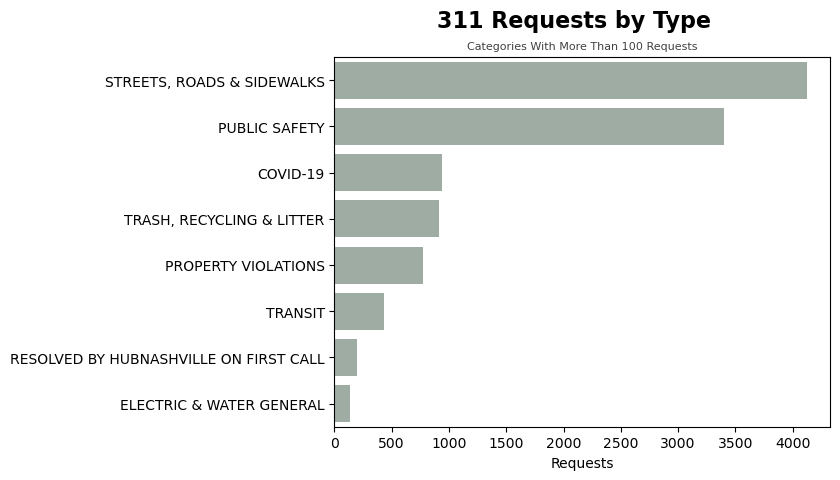

In [22]:
sns.barplot(x = 'requests', y = 'request_type', data = request_volume[request_volume['requests']>= 100], color = '#9DAEA3', dodge = False)
plt.suptitle('311 Requests by Type', fontsize=16, weight='bold')
plt.title('Categories With More Than 100 Requests', fontsize=8, alpha=0.75)
plt.ylabel('')
plt.xlabel('Requests')
plt.savefig('../plots/request_types.png', bbox_inches='tight', transparent=True);

Interestingly, there are almost 30,000 entries related to road and sidewalk conditions - over 4 times the number of crashes along the corridor... Let's dig into those.

In [23]:
road_requests = nash_311[nash_311['case_request'] == 'STREETS, ROADS & SIDEWALKS']['case_subrequest'].value_counts().rename_axis('subrequest').reset_index(name = 'requests')
road_requests

,subrequest,requests
0,BLOCKING THE RIGHT OF WAY,1057
1,TRAFFIC LIGHT ISSUE,1012
2,POTHOLES,373
3,DAMAGED SIGN,250
4,TRAFFIC LIGHT TIMING,149
5,TRAFFIC ENGINEERING,140
6,DEAD ANIMAL PICKUP,129
7,SIDEWALKS,124
8,STREET LIGHTING,108
9,ROADWORK COMPLAINT,105


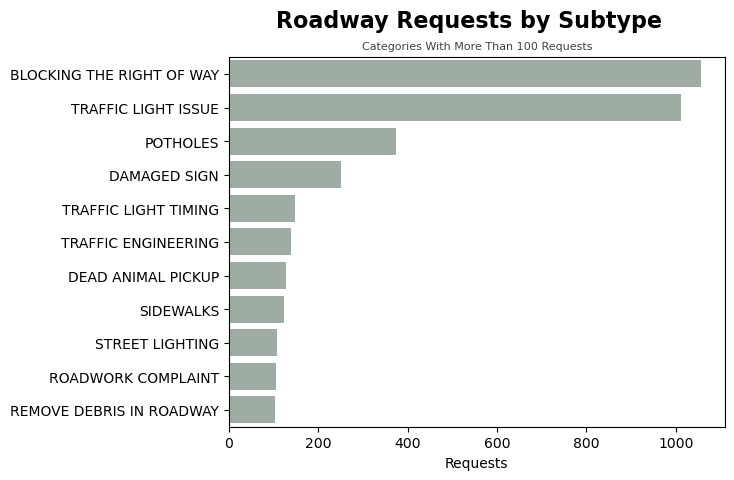

In [24]:
sns.barplot(x = 'requests', y = 'subrequest', data = road_requests[road_requests['requests']>= 100], color = '#9DAEA3', dodge = False)
plt.suptitle('Roadway Requests by Subtype', fontsize=16, weight='bold')
plt.title('Categories With More Than 100 Requests', fontsize=8, alpha=0.75)
plt.ylabel('')
plt.xlabel('Requests')
plt.savefig('../plots/road_requests.png', bbox_inches='tight', transparent=True);

While there aren't many, several subcategories related to infrastructure issues include requests for improvements. Plotting those on a map and comparing against crash locations will tell us where residents think the problem areas are.

In [25]:
impr_requests = nash_311[nash_311['case_subrequest'].isin(['Request New Sign', 'Traffic Engineering', 'Paving Request', 'Request a Speed Monitor Trailer', 'Traffic Light Timing', 'Request New Signal', 'Traffic Calming', 'Request for a New/Improved Bikeway', 'Request Warning Sign'])]
impr_requests.to_csv(('../data/clean/impr_requests.csv'))
impr_requests.head()

,Unnamed: 0,case_number,status,case_request,case_subrequest,additional_subrequest,date_time_opened,date_time_closed,case_origin,state_issue,...,incident_address,incident_city,incident_council_district,incident_zip_code,latitude,longitude,mapped_location,contact_type,parent_case,preferred_language


Another consideration is traffic signal equipment and whether or not proper pedestrian facilities exist.

In [26]:
ped_inv = pd.read_csv('../data/clean/ped_inv.csv')
ped_inv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       239 non-null    int64  
 1   intersectionid   239 non-null    int64  
 2   onst             239 non-null    object 
 3   crst             239 non-null    object 
 4   quad             239 non-null    object 
 5   inspector        239 non-null    object 
 6   date             239 non-null    object 
 7   evnt_lat         238 non-null    float64
 8   evnt_lon         238 non-null    float64
 9   evnt_map         239 non-null    object 
 10  evnt_type        148 non-null    object 
 11  ped_signal_pres  239 non-null    bool   
 12  oa_cmnt          239 non-null    object 
 13  mapped_location  238 non-null    object 
 14  cpl_size         148 non-null    object 
 15  cpl_force        148 non-null    object 
 16  cpl_op           148 non-null    object 
 17  cpl_ctrst       

In [27]:
non_complaince = ped_inv[ped_inv.isin([False]).any(axis=1)].groupby('intersectionid').count()
len(non_complaince)

33

In [28]:
no_ped = ped_inv[ped_inv['ped_signal_pres'] == False].groupby('intersectionid').count()
len(no_ped)

24

In [29]:
len(ped_inv.groupby('intersectionid').count())

35

Now let's get this information into Microsoft PowerBI to look at it graphically.

PowerBI created some useful graphs, but I still can't explain that drop in crashes. Let's try it here.

In [35]:
crashes_drop = pd.read_csv('../data/clean/crashes_filtered.csv')
crashes_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0.2                715 non-null    int64  
 1   Unnamed: 0.1                715 non-null    int64  
 2   Unnamed: 0                  715 non-null    int64  
 3   accident_number             715 non-null    int64  
 4   date_and_time               715 non-null    object 
 5   number_of_motor_vehicles    715 non-null    float64
 6   number_of_injuries          715 non-null    float64
 7   number_of_fatalities        715 non-null    float64
 8   hit_and_run                 715 non-null    bool   
 9   reporting_officer           715 non-null    float64
 10  collision_type_description  715 non-null    object 
 11  weather_description         715 non-null    object 
 12  illumination_description    715 non-null    object 
 13  harmfuldescriptions         715 non

In [37]:
crashes_drop['date'].value_counts()

date
2023-02-23    8
2023-03-06    7
2023-04-14    7
2023-03-03    7
2022-12-14    7
             ..
2022-11-29    1
2023-03-20    1
2023-03-18    1
2022-12-04    1
2022-11-27    1
Name: count, Length: 305, dtype: int64